In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost

### Wczytanie danych

In [2]:
file = pd.read_stata('hctms_data.dta')

### Wybrane zmienne
##### Ilościowe
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q32** - wiek partnera w 2017

##### Jakościowe
- **Q27** - czy ty i twój partner dorastaliście w tym samym mieście?
- **w6_q32**- czy wykorzystałeś internet do poznania partnera?

### Przetworzenie danych i faktoryzacja zmiennych jakościowych

In [3]:
dt = file[['w6_number_people_met','age_when_met','Q9', 'ppage','w6_q32','S1','Q27','w6_q21b_year','w6_q21c_year','Q21A_Year','w6_q9']].dropna().reset_index(drop = True)

In [4]:
# S1 - Is married?
dt['S1'] = 1 - dt['S1'].cat.codes

dt['ppage'] = pd.to_numeric(dt['ppage'])

# w6_q32 - Did you use internet to meet partner?
dt['w6_q32'] = dt['w6_q32'].str.replace('No.*','0')
dt['w6_q32'] = dt['w6_q32'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['w6_q32'] == 'Refused')]
dt['w6_q32'] = pd.to_numeric(dt['w6_q32'])

# Q27 - The same city with partner?
dt['Q27'] = dt['Q27'].str.replace('No.*','0')
dt['Q27'] = dt['Q27'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['Q27'] == 'Refused')]
dt['Q27'] = pd.to_numeric(dt['Q27'])

# Q9 - The same city with partner?
dt = dt.loc[~(dt['Q9'] == 'Refused')]
dt['Q9'] = pd.to_numeric(dt['Q9'])

# Q21A_Year - In what Year and Month did you first meet 
dt = dt.loc[~(dt['Q21A_Year'] == 'Refused')]
dt['Q21A_Year'] = pd.to_numeric(dt['Q21A_Year'])

# w6_q9 - Partner age in 2017

features = dt[['Q21A_Year','w6_q9','Q27','w6_q32']]
#features = dt[['w6_q21b_year','w6_q21c_year','Q27','w6_q32']]
#features = dt[['Q9','ppage','Q27','w6_q32']]
labels = dt[['S1']]

In [5]:
features.head(10)

,Q21A_Year,w6_q9,Q27,w6_q32
0,1983,52.0,0,0
1,2006,45.0,0,1
2,1983,59.0,0,0
3,1981,60.0,0,0
4,1966,67.0,1,0
5,1967,65.0,1,0
6,2008,43.0,0,0
7,2007,35.0,0,0
8,2002,42.0,0,0
9,2007,37.0,0,0


In [6]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features.values, labels, test_size = 0.10, random_state = 0)

#XGBoost
from xgboost import XGBClassifier
model_xgb = XGBClassifier(max_depth=3)
model_xgb.fit(train_features,train_labels)
predictions = model_xgb.predict(test_features)
tested_labels = np.array(test_labels)
model_xgb.score(test_features,test_labels)
model_xgb.predict(test_features)
model_xgb.predict_proba(test_features)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_xgb, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+str(cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 84.43490052590437 %


### Funkcja do rysowania PD-plot, M-plot i ALE-plot
Dodakowo rysuje profile Ceterus Paribus dla wszystkich obserwacji ze zbioru features

In [7]:
def explain_model(model, features, feature_index, window):
    '''
    features - pandas DF
    feature_index - index kolumny dla której robimy wykresy
    '''
    
    colnames = list(features.columns)
    features = features.values
      
    # Draw figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    # Ceteris Paribus lines for all observations and PD-plot
    unique_features = np.sort(np.unique(features[:,feature_index]))
    all_proba = []
    for j in range(features.shape[0]):
        x_to_predict = np.tile(features[j],(len(unique_features),1))
        x_to_predict[:,feature_index] = unique_features
        y = model.predict_proba(x_to_predict)[:,1]
        all_proba.append(y)
        axes[0].plot(unique_features,y, color = '0.75', zorder = 5)
    axes[0].scatter(features[:,feature_index], model.predict_proba(features.tolist())[:,1], c = 'black', s = 15, zorder = 10)
    axes[0].plot(unique_features, np.mean(all_proba, axis = 0), color = 'black',linewidth = 5 , zorder = 15, label = 'PD plot')
    
    # Magrinal effect plot and ALE plot data
    min_value, max_value = int(min(features[:,feature_index])), int(max(features[:,feature_index]))
    m_plot = []
    ale = []
    for i in range(min_value, max_value):
        # M-plot
        window_avg = np.mean(np.array(all_proba)[(features[:,feature_index] >= i - window) & (features[:,feature_index] < i + window)])
        m_plot.append(window_avg)
        
        #ALE-plot
        window_features = features[(features[:,feature_index] >= i - window) & (features[:,feature_index] < i + window)].copy()
        window_features[:,feature_index] = i - window
        proba_lower = model.predict_proba(window_features)[:,1]
        window_features[:,feature_index] = i + window
        proba_higher = model.predict_proba(window_features)[:,1]
        ale.append(np.mean((proba_higher - proba_lower)))
    
    ale = np.array(ale).cumsum()
    ale = ale - np.mean(ale)
        
    # M-plot
    axes[0].plot(range(min_value,max_value), m_plot, color = 'red',linewidth = 5 , zorder = 15, label = 'M-plot')
    
    # Plot features
    axes[0].set_title('PD-plot and M-plot for ' + colnames[feature_index])
    axes[0].legend()
    
    # ALE-plot
    axes[1].plot(range(min_value,max_value), ale, color = 'blue',linewidth = 5 , zorder = 15, label = 'ALE-plot')
    axes[1].set_title('ALE-plot for ' + colnames[feature_index])
    axes[1].legend()

### Eksperyment

Do porównania wybrałem 2 zmienne ilościowe o dosyć dużej ujemnej korelacji:
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q32** - wiek partnera w 2017

Na wykresach po lewej stronie widać profile Ceteris Paribus dla wszystkich próbek i grubą czarną linię czyli PD-plot. Płaskie profile Ceteris Paribus znaczą miej więcej tyle, że zmienna nie ma zbyt dużego wpływu na wynik modelu. Jednak w przypadku zmiennej **w6_q9** możemy zauważyć dosyć dużą różnicę między profilami PD-plot i M-plot, ogólny trend zmiany prawdopodobieństwa czy dana osoba jest zamężna wraz wiekiem partnera rośnie. Jest to według mnie bardzo użyteczna informacja, której sam wykres Ceterus Paribus nie byłby w stanie pokazać.

Po prawej stronie są narysowane wykresy ALE-plot dla zmiennych. Dla atrybutu **Q21A_Year** widać, że profil ALE bardzo przypomina wykres PD-plot, ponieważ większość danych jest skupiona bardzo blisko siebie w jednej linii. Także właśnie w taki sposób zmienia się prawdopodobieństwo bycia zamężnym w zależności od roku w którym badany poznał partnera. Jeżeli chodzi o zmienną **w6_q32** to można zauważyć, że ALE-plot jest świetnym dodatkiem do podstawowego Ceterus Paribus, ponieważ dla okienek o szerokości $10$ do wieku partnera równego $40$ prawdopodobieństwa rosną, natomiast potem maleją i się stabilizują. Pokazuje to, że gdy wykluczylśmy bezsensowne próbki, takie jak $60$-letni partner urodzony w $2010$ roku, możemy o wiele czytelniej wyjaśnić model przy pomocy ALE-plota.

Podsumowując - najlepiej podczas próby wyjaśnienia modelu wykorzystać jak najwięcej zróżnicowanych wykresów, żeby jak najlepiej zrozumieć problem.

In [11]:
features.iloc[:,0:2].corr()

,Q21A_Year,w6_q9
Q21A_Year,1.00000,-0.79492
w6_q9,-0.79492,1.00000


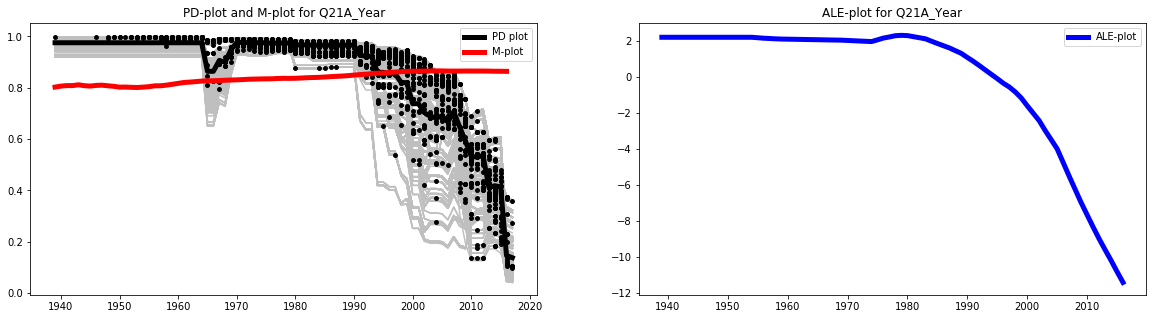

In [8]:
explain_model(model_xgb, features, 0, 10)

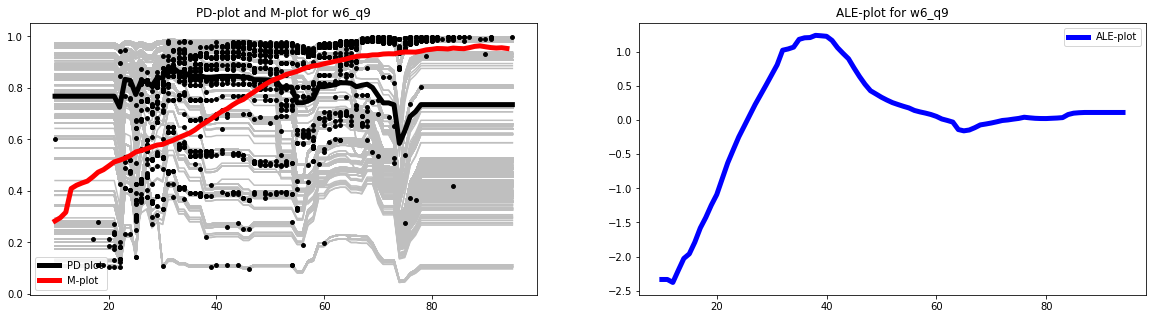

In [9]:
explain_model(model_xgb, features, 1, 10)